<a href="https://colab.research.google.com/github/LOV8D/hackathon/blob/main/Copy_of_Playground_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


***
1.   migrate to langgraph
2.   add reviewer
3.   split retrieval funcitons to people, project agents
4.   add viz
***



## **My Tries**

In [3]:
import openai
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, AgentExecutor, Tool, ZeroShotAgent
from langchain.memory import ConversationBufferMemory
import faiss
import pandas as pd
import numpy as np
import os

# Set OpenAI API key
# openai_api = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Hackathon/openai_api.xlsx').iloc[0,0]
# openai.api_key = openai_api


In [4]:

import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Multi-agent TT"

In [5]:
import pandas as pd

# Paths to files in Google Drive
people_file = '/content/drive/MyDrive/Colab Notebooks/Hackathon/Employees.xlsx'
projects_file = '/content/drive/MyDrive/Colab Notebooks/Hackathon/project_descriptions.csv'
allocation_file = '/content/drive/MyDrive/Colab Notebooks/Hackathon/allocation_table.xlsx'

# Load data
people_data = pd.read_excel(people_file)
project_data = pd.read_csv(projects_file)
initial_allocation = pd.read_excel(allocation_file)
project_data.rename(columns={'Project Name':'name'}, inplace=True)
people_data

,Name,Role,Skills,Vacation Time,PiT Capacity,Performance Review,Communication Preference,Management Advice,1on1s
0,Judy,Quantitative Analyst AVP,"Machine Learning\nPython, C++\nFinancial Modeling",1/1/2025 - 2/1/2025\n6/1/2025-6/7/2025,Yes,Outstanding,English and Korean,She is good at managing projects with abundant...,Yes
1,Alice,Quantitative Analyst VP,"Machine Learning\nPython, R\nFinancial Modeling",5/1/2025 - 6/1/2025\n8/1/2025-8/15/2025,No till 2/1/2025,Outstanding,English,Now busy on an important project,Yes
2,Susan,Quantitative Analyst AVP,"Accounting\nPython, R\nFinancial Modeling",1/15/2025 - 2/15/2025\n3/18/2025-3/27/2025,Yes,Good,English and Chinese,She is a technical person with accounting expe...,Yes
3,Tom,Quantitative Analyst AVP,Equity Research\nPython\nFinancial Modeling,1/15/2025 - 2/15/2025\n11/1/2025-11/7/2025,Yes,Outstanding,English and Chinese,He is the best friend with Susan,Yes
4,Jack,Financial Analyst AVP,Python\nFinancial Modeling\nAccounting,4/1/2025 - 6/1/2025,Yes,Good,English,Very new to the team,Yes
5,Kyle,Financial Analyst VP,"Accounting\nPython, R\nFinancial Modeling",\n6/1/2025-6/7/2025,No till 3/1/2025,Outstanding,English,Many years of experience senior VP,Yes
6,Alex,Software Development Engineer VP,"Computer Science\nPython, C++",6/1/2025 - 7/1/2025\n11/1/2025-11/15/2025,Yes,Outstanding,English,Senior SDE in the team,Yes
7,Maria,Software Development Engineer AVP,"Computer Science\nPython, C++",1/1/2025 - 2/1/2025\n6/1/2025-6/7/2025,Yes,Good,English and Japanese,Junior SDE also speaking Japanese,Yes
8,Jane,Software Development Engineer AVP,"Computer Science\nPython, C++",1/15/2025 - 2/15/2025\n3/18/2025-3/27/2025,Yes,Outstanding,English,Very active and responsive,Yes
9,Christina,Human Resource Analyst,Project Management\nCommunication,5/1/2025 - 6/1/2025\n8/1/2025-8/15/2025,Yes,Outstanding,English,Good presentation skills,Yes


In [6]:
project_data

,name,Description
0,**Project 1: Equity Valuation Model**,Developed a comprehensive equity valuation mod...
1,**Project 2: Algorithmic Trading Bot**,Engineered an algorithmic trading bot using Py...
2,**Project 3: Sentiment Analysis for Stock Pred...,Created a sentiment analysis tool that scraped...
3,**Project 4: Portfolio Optimization Dashboard**,Designed an interactive dashboard in R Shiny f...
4,**Project 5: Risk Management Simulation**,Developed a Monte Carlo simulation tool to ass...


In [7]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

# Initialize embedding model
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# Generate combined descriptions for each person
people_descriptions = (people_data['Name'] + " is a " + people_data['Role'] + " with skills in " + people_data['Skills']).tolist()
project_descriptions = (project_data['name'] + ": " + project_data['Description']).tolist()
# Generate embeddings
person_embeddings = embeddings.embed_documents(people_descriptions)
project_embeddings = embeddings.embed_documents(project_descriptions)
# Initialize FAISS index and add embeddings
dimension = len(person_embeddings[0])  # Dimensionality of embeddings
project_index = faiss.IndexFlatL2(dimension)
person_index = faiss.IndexFlatL2(dimension)

project_index.add(np.array(project_embeddings))
person_index.add(np.array(person_embeddings))

faiss.write_index(project_index, "project_index.faiss")
faiss.write_index(person_index, "person_index.faiss")


# Save the FAISS index to Google Drive
# faiss.write_index(faiss_index, '/content/drive/MyDrive/Colab Notebooks/Hackathon/faiss_people_index.index')


<ipython-input-7-f03c75f85155>:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")


In [8]:
import faiss

faiss_index = faiss.read_index('/content/drive/MyDrive/Colab Notebooks/Hackathon/faiss_people_index.index')

In [9]:
# Initialize availability and capacity per quarter for each person
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

# Assume full availability and capacity initially
for quarter in quarters:
    people_data[f'{quarter}_available'] = True
    people_data[f'{quarter}_capacity'] = people_data['PiT Capacity']

# Adjust availability based on vacation time
def adjust_availability(row):
    if pd.notnull(row['Vacation Time']):
        vacation_times = str(row['Vacation Time']).split(',')
        for vt in vacation_times:
            vt = vt.strip()
            if vt in quarters:
                row[f'{vt}_available'] = False
    return row

people_data = people_data.apply(adjust_availability, axis=1)

In [10]:
# Define function to retrieve similar people considering availability and capacity
def retrieve_similar_people(project_description, quarter, top_k=5):
    # Embed project description
    project_embedding = np.array([embeddings.embed_query(project_description)]).astype('float32')

    # Perform similarity search in FAISS
    distances, indices = faiss_index.search(project_embedding, len(people_data))  # Search over all

    # Retrieve corresponding candidate data
    candidate_info = []
    for idx in indices[0]:
        person_row = people_data.iloc[idx]
        if person_row[f'{quarter}_available'] and person_row[f'{quarter}_capacity'] > 0:
            candidate_info.append({
                "Name": person_row['Name'],
                "Role": person_row['Role'],
                "Skills": person_row['Skills'],
                "Performance Review": person_row['Performance Review'],
                "Capacity": person_row[f'{quarter}_capacity']
            })
            if len(candidate_info) >= top_k:
                break
    return candidate_info

In [11]:
# Prepare combined project data
projects_info = []
for _, project in project_data.iterrows():
    project_info = {
        'name': project['name'],
        'description': project['Description'],
        'constraints': project.get('constraints', 'should be at least 2 candidates')
    }
    projects_info.append(project_info)

# Prepare combined candidate data
candidates_info = []
for idx, person_row in people_data.iterrows():
    candidate = {
        "Name": person_row['Name'],
        "Role": person_row['Role'],
        "Skills": person_row['Skills'],
        "Performance Review": person_row['Performance Review'],
        "Capacity": {quarter: person_row[f'{quarter}_capacity'] for quarter in quarters},
        "Availability": {quarter: person_row[f'{quarter}_available'] for quarter in quarters}
    }
    candidates_info.append(candidate)


In [18]:
projects_info

[{'name': '**Project 1: Equity Valuation Model**',
  'description': 'Developed a comprehensive equity valuation model using discounted cash flow (DCF) analysis for a portfolio of tech stocks, which provided insights into fair value estimates. Leveraged advanced Excel functionality and Python for data analysis, resulting in a 15% improved accuracy in predicting stock price movements. The project showcased my skills in financial modeling, data visualization, and quantitative analysis.',
  'constraints': 'should be at least 2 candidates'},
 {'name': '**Project 2: Algorithmic Trading Bot**',
  'description': 'Engineered an algorithmic trading bot using Python and the Alpaca API, designed to execute trades based on quantitative signals derived from historical price data. The bot achieved a 20% return on investment over six months, outperforming the S&P 500. This project honed my skills in machine learning, backtesting frameworks, and real-time data processing.',
  'constraints': 'should be 

In [13]:
# Function to format projects for the prompt
def format_projects(projects):
    projects_str = ""
    for project in projects:
        projects_str += f"Project Name: {project['name']}\nDescription: {project['description']}\nConstraints: {project['constraints']}\n"
    return projects_str

# Function to format candidates for the prompt
def format_all_candidates(candidates):
    candidates_str = ""
    for candidate in candidates:
        capacities = ', '.join([f"{q}: {candidate['Capacity'][q]}" for q in quarters])
        availabilities = ', '.join([f"{q}: {candidate['Availability'][q]}" for q in quarters])
        candidates_str += f"Name: {candidate['Name']}, Role: {candidate['Role']}, Skills: {candidate['Skills']}, Performance Review: {candidate['Performance Review']}, Capacities: {capacities}, Availabilities: {availabilities}\n"
    return candidates_str

# Prepare the formatted strings
projects_str = format_projects(projects_info)
candidates_str = format_all_candidates(candidates_info)


In [14]:
projects_str

'Project Name: **Project 1: Equity Valuation Model**\nDescription: Developed a comprehensive equity valuation model using discounted cash flow (DCF) analysis for a portfolio of tech stocks, which provided insights into fair value estimates. Leveraged advanced Excel functionality and Python for data analysis, resulting in a 15% improved accuracy in predicting stock price movements. The project showcased my skills in financial modeling, data visualization, and quantitative analysis.\nConstraints: should be at least 2 candidates\nProject Name: **Project 2: Algorithmic Trading Bot**\nDescription: Engineered an algorithmic trading bot using Python and the Alpaca API, designed to execute trades based on quantitative signals derived from historical price data. The bot achieved a 20% return on investment over six months, outperforming the S&P 500. This project honed my skills in machine learning, backtesting frameworks, and real-time data processing.\nConstraints: should be at least 2 candidat

In [15]:
# Adjust the assignment prompt template
assignment_prompt_template = PromptTemplate(
    input_variables=["projects", "candidates"],
    template="""
You are the Assignment Agent responsible for assigning candidates to projects across all quarters.

Projects:
{projects}

Candidates:
{candidates}

Constraints:
- Ensure that each candidate is not assigned beyond their capacity for each quarter.
- Candidates must be available in the quarter they are assigned.
- Match candidate skills and roles with project requirements.
- Consider performance reviews when selecting candidates.

Your task is to assign the best candidates to each project for each quarter.

Provide the assignments in the following JSON format:

[
    {{
        "Project": "Project Name",
        "Assignments": {{
            "Q1": ["Candidate Name 1", "Candidate Name 2"],
            "Q2": ["Candidate Name 3"],
            "Q3": [],
            "Q4": ["Candidate Name 4"]
        }}
    }},
    ...
]

Ensure the JSON is valid and parsable.
"""
)
# Prompt template for LLM chain
prompt_template = PromptTemplate(
    input_variables=["project", "candidates", "constraints"],
    template="""
Project requirements:
{project}

Candidates:
{candidates}

Additional constraints:
{constraints}

Recommend the best candidate for this project, considering each candidate’s capacity, performance, and availability.
Provide only the name of the selected candidate.
"""
)
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai.api_key)
llm_chain = LLMChain(prompt=prompt_template, llm=llm)

<ipython-input-15-ca46b4e755c4>:56: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai.api_key)
<ipython-input-15-ca46b4e755c4>:57: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(prompt=prompt_template, llm=llm)


In [16]:
# Initialize the assignment chain
assignment_chain = LLMChain(prompt=assignment_prompt_template, llm=llm)

# Create the input for the assignment agent
input_dict = {
    "projects": projects_str,
    "candidates": candidates_str
}

# Run the assignment agent
assignment_output = assignment_chain.run(input_dict)


<ipython-input-16-c23fbfdf02ee>:11: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  assignment_output = assignment_chain.run(input_dict)


In [17]:
assignment_output

'```json\n[\n    {\n        "Project": "Project 1: Equity Valuation Model",\n        "Assignments": {\n            "Q1": ["Judy", "Tom"],\n            "Q2": ["Judy", "Tom"],\n            "Q3": ["Judy", "Tom"],\n            "Q4": ["Judy", "Tom"]\n        }\n    },\n    {\n        "Project": "Project 2: Algorithmic Trading Bot",\n        "Assignments": {\n            "Q1": ["Judy", "Alex"],\n            "Q2": ["Judy", "Alex"],\n            "Q3": ["Judy", "Alex"],\n            "Q4": ["Judy", "Alex"]\n        }\n    },\n    {\n        "Project": "Project 3: Sentiment Analysis for Stock Predictions",\n        "Assignments": {\n            "Q1": ["Judy", "Tom"],\n            "Q2": ["Judy", "Tom"],\n            "Q3": ["Judy", "Tom"],\n            "Q4": ["Judy", "Tom"]\n        }\n    },\n    {\n        "Project": "Project 4: Portfolio Optimization Dashboard",\n        "Assignments": {\n            "Q1": ["Susan", "Jack"],\n            "Q2": ["Susan", "Jack"],\n            "Q3": ["Susan", "Jac

## 1. Langgraph - manager only - BL on

In [23]:
from typing import Annotated, List, Tuple, Union
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
import random
import numpy as np
import matplotlib.pyplot as plt

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [30]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor
  # agent node
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [25]:
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai.api_key)

In [46]:
@tool("analyze_tool")
def analyze_tool(input_dict:dict):
  '''
  Initiate or update the project plan.

  Args:
    input_dict = {
      "projects": projects_str,
      "candidates": candidates_str
  }
  '''
  # Adjust the assignment prompt template
  assignment_prompt_template = PromptTemplate(
      input_variables=["projects", "candidates"],
      template="""
  You are the Assignment Agent responsible for assigning candidates to projects across all quarters.

  Projects:
  {projects}

  Candidates:
  {candidates}

  Constraints:
  - Ensure that each candidate is not assigned beyond their capacity for each quarter.
  - Candidates must be available in the quarter they are assigned.
  - Match candidate skills and roles with project requirements.
  - Consider performance reviews when selecting candidates.

  Your task is to assign the best candidates to each project for each quarter.

  Provide the assignments in the following JSON format:

  [
      {{
          "Project": "Project Name",
          "Assignments": {{
              "Q1": ["Candidate Name 1", "Candidate Name 2"],
              "Q2": ["Candidate Name 3"],
              "Q3": [],
              "Q4": ["Candidate Name 4"]
          }}
      }},
      ...
  ]

  Ensure the JSON is valid and parsable.
  """
  )
  assignment_chain = LLMChain(prompt=assignment_prompt_template, llm=llm)
  return assignment_chain.run(input_dict)


@tool("retrieve_project")
def retrieve_project():
  '''
  Retrieve all projects.
  '''
  project_data = pd.read_csv(projects_file)
  project_data.rename(columns={'Project Name':'name'}, inplace=True)

  projects_info = []
  for _, project in project_data.iterrows():
      project_info = {
          'name': project['name'],
          'description': project['Description'],
          'constraints': project.get('constraints', 'should be at least 2 candidates')
      }
      projects_info.append(project_info)

  projects_str = ""
  for project in projects_info:
      projects_str += f"Project Name: {project['name']}\nDescription: {project['description']}\nConstraints: {project['constraints']}\n"

  return projects_str

@tool("retrieve_candidate")
def retrieve_candidate():
  '''
  Retrieve all candidates.
  '''
  candidates_info = []
  for idx, person_row in people_data.iterrows():
      candidate = {
          "Name": person_row['Name'],
          "Role": person_row['Role'],
          "Skills": person_row['Skills'],
          "Performance Review": person_row['Performance Review'],
          "Capacity": {quarter: person_row[f'{quarter}_capacity'] for quarter in quarters},
          "Availability": {quarter: person_row[f'{quarter}_available'] for quarter in quarters}
      }
  candidates_info.append(candidate)
  candidates_str = ""
  for candidate in candidates_info:
      capacities = ', '.join([f"{q}: {candidate['Capacity'][q]}" for q in quarters])
      availabilities = ', '.join([f"{q}: {candidate['Availability'][q]}" for q in quarters])
      candidates_str += f"Name: {candidate['Name']}, Role: {candidate['Role']}, Skills: {candidate['Skills']}, Performance Review: {candidate['Performance Review']}, Capacities: {capacities}, Availabilities: {availabilities}\n"

  return candidates_str


In [47]:
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

first_prompt = '''
    You are the Assignment Agent responsible for assigning candidates to projects across all quarters.
'''
first_agent = create_agent(llm,
                      tools = [retrieve_candidate, retrieve_project, analyze_tool],
                      system_prompt = first_prompt)
first_node = functools.partial(agent_node, agent=first_agent, name="first_agent")


workflow = StateGraph(AgentState)
workflow.add_node("first", first_node)
workflow.set_entry_point('first')
graph = workflow.compile()

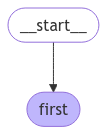

In [48]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [49]:
config = {"recursion_limit": 10}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Draw me a table on current project status for each employee for each project.")
        ]
    }, config=config
):
    if "__end__" not in s:
        print(s)
        print("----")

{'first': {'messages': [HumanMessage(content="To create a table for the current project status for each employee across the projects, we need to summarize the information we have about the candidates and the projects. Below is a table outlining the current status based on the provided information:\n\n| **Employee Name** | **Role**                     | **Project 1** | **Project 2** | **Project 3** | **Project 4** | **Project 5** |\n|--------------------|------------------------------|----------------|----------------|----------------|----------------|----------------|\n| Christina          | Human Resource Analyst        | Not Assigned    | Not Assigned    | Not Assigned    | Not Assigned    | Not Assigned    |\n\n### Notes:\n- The projects require at least 2 candidates, and currently, only one candidate (Christina) is available.\n- To fill in the table accurately, we need more candidates assigned to the projects.\n- If there are more candidates available, we can further update the tab

In [58]:
s['first']['messages'][0].content

"To create a table for the current project status for each employee across the projects, we need to summarize the information we have about the candidates and the projects. Below is a table outlining the current status based on the provided information:\n\n| **Employee Name** | **Role**                     | **Project 1** | **Project 2** | **Project 3** | **Project 4** | **Project 5** |\n|--------------------|------------------------------|----------------|----------------|----------------|----------------|----------------|\n| Christina          | Human Resource Analyst        | Not Assigned    | Not Assigned    | Not Assigned    | Not Assigned    | Not Assigned    |\n\n### Notes:\n- The projects require at least 2 candidates, and currently, only one candidate (Christina) is available.\n- To fill in the table accurately, we need more candidates assigned to the projects.\n- If there are more candidates available, we can further update the table with their respective project assignments.